# Comptétion Kaggle RSNA-MICCAI Brain Tumor Radiogenomic Classification
---



## Contexte

Ce notebook regroupe les travaux présentés dans le cadre de la compétition [Kaggle RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification). Le concours s'est terminé le 16 ocotbre 2021. 

Il portait sur la détection de la présence d'un marqueur biologique significatif dans le traitement du cancer du cerveau. 

[Le dataset fourni](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/data) regroupe un ensemble de clichés issu d'IRM réalisés sur des cohortes ed patients.

Le [kernel Kaggle que j'ai soumis](https://www.kaggle.com/cedricsoares/tf-efficientnet-transfer-learning-strat-split) pour la compétition se base sur [celui](https://www.kaggle.com/billqi/efficientnet-transfer-learning-model-full) partagé par [Bill Qi](https://www.kaggle.com/billqi).

À l'issu du concours les travaux m'ont permis d'atteindre la troisème place du [classement général](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/leaderboard) avec une AUC de 0.61732.

## Modèle et hypothèse de prédiction

EfficientNet-B3 a été utilisé pour le concours. 

Pour chaque patient quatre types différents de clichés d'IRM ont été référencés dans le dataset (flair, t1w, t1wce, t2w).

Un modèle différent a été entrâiné par type de cliché. Chaque modèle retournait la probabilité de présence du biomarqueur. 

La prédiction finale est obtenue par aggrégation des résultat par patient. L'équart entre la probabilité la plus haute et la moyenne des probabilités sur les différents modèles  est comparée à l'équart entre la moyenne et la probabilité la plus faible la plus faible. La probabilité liée au plus grand écart est retenue.

## Amélioration apportées au kernel initial 

Plusieurs ajouts et modifications lui ont été apporté:
* Ajout d'une partition train / validation stratifiée par patient et classe de présence du biomarqueur.


* Modification de la résolution de 224 x 224 à 300 x 300 afin de se mettre en conformité avec la résolution utilisée lors de l'entrainement initial du modèle
Entrainement des modèles sur 20 epochs au lieu de 5.

* Ajout d'une couche supplémentaire de batch normalization et de drop out au niveaux des couches totalement connectées.

* Modification du niveau de drop out sur la couche existante (0.1 à 0.4).


* Ajout d'un callback d'early stopping afin d'arrêter l'entraînement des modèles si la fonction de coût ne minimise plus sur le jeu de validation pendant 5 epochs.


* Ajout d'un callback de réduction du learning rate si la fonction de coût ne minise plus sur le jeu de validation pendant 2 epochs.


* Plusieurs valeurs de batch size ont été évalue (32, 64, 128, 256, 512) vs 512 dans le kernel initial. La valeur 128 a été retenue. 

## Éléments à récupérer sur Kaggle:

* [Données](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv):  (136.85 GB, ne peut être contenu dans une VM Google Colab ou Colab+)


- [Poids du modèle pé-entraîné](https://www.kaggle.com/pansofluck/efficentnet-b0b5-tensorflow-24-notop?select=efficientnet-b3_tf24_imagenet_1000_notop.h5) :  (43.95 MB)

## Initialisation du projet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade pip
!pip install kaggle==1.5.6
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 58 kB 4.0 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=c88ff5936fa7b5040ef99aa84d18a5771c4fdd8ea2ab5dfa28493b52d3482743
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
import math
import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


import random
#from random import sample
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import pydicom
import cv2



root_dir = <path_dossier_dataset>
df = pd.read_csv(root_dir+'train_labels.csv')

### Ajout du chemin d'accès de chaque fichier dans le dataframe

In [ ]:
# Add the full paths for each id for different types of sequences to the csv 
def full_ids(data):
    zeros = 5 - len(str(data))
    if zeros > 0:
        prefix = ''.join(['0' for i in range(zeros)])
    
    return prefix+str(data)
        

df['BraTS21ID_full'] = df['BraTS21ID'].apply(full_ids)

# Add all the paths to the df for easy access
df['flair'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/FLAIR/')
df['t1w'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/T1w/')
df['t1wce'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/T1wCE/')
df['t2w'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/T2w/')

In [ ]:
df_test = pd.read_csv(root_dir+'sample_submission.csv')

df_test['BraTS21ID_full'] = df_test['BraTS21ID'].apply(full_ids)

# Add all the paths to the df for easy access
df_test['flair'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/FLAIR/')
df_test['t1w'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/T1w/')
df_test['t1wce'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/T1wCE/')
df_test['t2w'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/T2w/')

## Chargement des images


### Construction de dataframes de partition train, validation, test

Certaines données ont été identifiés comme partiellement complètes par organisateurs du concours. :

* Patient 00109 (FLAIR: clichés manquants)
* Patient 00123 (T1w:  clichés manquants)
* Patient 00709 (FLAIR: clichés manquants)

Le dataframe initial est reformaté afin d'obtenir des dataframes spécifiques pour chaque partition train, validation, test.

Il seront utilisés dans un itérateur appelé pour générer les batch et y appliquer la data augmentation.

Initailement les données sont partitionnées entre train et test.
Pour le projet une partition de validation supplémentaire a été crée à partir de la partition train. 

La partition 90% train / 10% validation a été réalisée de manière stratifiée sur les numéros de patients et par classe. 

In [ ]:
def get_train_val_dataframe(mri_type):
    
    all_img_files = []
    all_img_labels = []
    all_img_patient_ids = []
    for row in df.iterrows():
        if row[1]['BraTS21ID_full'] == '00109' and mri_type == 'flair':
            continue
        if row[1]['BraTS21ID_full'] == '00123' and mri_type == 't1w':
            continue
        if row[1]['BraTS21ID_full'] == '00709' and mri_type == 'flair':
            continue
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.dcm', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.dcm' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+ele for ele in img_names]
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_img_files.extend(img_paths)
        all_img_labels.extend(img_labels)
        all_img_patient_ids.extend(img_patient_ids)

    train_val_df = pd.DataFrame({'patient_ids': all_img_patient_ids,
                  'labels': all_img_labels,
                  'file_paths': all_img_files})

    train_val_df['labels'] = train_val_df['labels'].map({1: '1', 0: '0'})
    
    #stratifiied 90% split on patient_ids and labels  
    class_prop= 0.90
    
    classes_splits  = {}
    for i in range(2):
        train_val_label_class = train_val_df[train_val_df['labels']==f'{i}']
        train_val_list_ids =  list(train_val_label_class['patient_ids'].unique())
        train_threshold = math.ceil(class_prop*len(train_val_list_ids))
        train_ids = train_val_list_ids[:train_threshold]
        val_ids = train_val_list_ids[train_threshold:]
        classes_splits[f'train_{i}'] = train_val_label_class[train_val_label_class['patient_ids'].isin(train_ids)]
        classes_splits[f'val_{i}'] = val_df = train_val_label_class[train_val_label_class['patient_ids'].isin(val_ids)]
        
    train_df = pd.concat([classes_splits['train_0'], classes_splits['train_1']], axis=0)
    val_df = pd.concat([classes_splits['val_0'], classes_splits['val_1']], axis=0)
  
    return train_df, val_df
    
def get_test_dataframe(mri_type):
    
    all_test_img_files = []
    all_test_img_labels = []
    all_test_img_patient_ids = []
    for row in df_test.iterrows():
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.dcm', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.dcm' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+ele for ele in img_names]
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_test_img_files.extend(img_paths)
        all_test_img_labels.extend(img_labels)
        all_test_img_patient_ids.extend(img_patient_ids)

    test_df = pd.DataFrame({'patient_ids': all_test_img_patient_ids,
                  'labels': all_test_img_labels,
                  'file_paths': all_test_img_files})
    
    test_df['labels'] = ['1']*(len(test_df)-1) + ['0'] # workaround for testing data gen
    
    return test_df

### Création de l'itérateur

L'itérateur est construit par héritage de la classe DataFrameIterator fournie par l'implémentation TensorFlow de Keras.

Dans la classe itérateur, une méthode spécifique est implémentée pour réaliser le pré-traitement des images. Un normailisation min-max est appliqué aux images.

In [ ]:
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(300, 300), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        pixels = image_array - np.min(image_array)
        pixels = pixels / np.max(pixels)
        image_manual_norm = (pixels * 255).astype(np.uint8)
        image_array = cv2.resize(image_manual_norm, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
#         image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = np.dstack((image_array, np.zeros_like(image_array), np.zeros_like(image_array)))
        return image_array

## Data augmentation 

La clase ImageDataGenerator de l'API Keras/TensorFlow est utillisée pour générer des batch de 128 images.

Les valeurs des pixels des images sont normalisées à une échelle 0 à 1 sur tout les jeux de donées.

Sur le jeu train plusieurs transformations de data augmentation sont appliquées:
* zoom
* rotation
* décalage vertical
* décalage horizontal
* retournement horizontal
* modification de la luminosité

In [ ]:
SEED = 369
BATCH_SIZE = 128
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (300, 300)

def get_data_generators(train_df,val_df, test_df):
    train_augmentation_parameters = dict(
        rescale=1.0/255,
        zoom_range=0.2,
        rotation_range=0.2,
        fill_mode='nearest',
        height_shift_range= 0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        brightness_range = [0.8, 1.2]
    )
    
    val_augmentation_parameters = dict(
        rescale=1.0/255.0
    )

    test_augmentation_parameters = dict(
        rescale=1.0/255.0
    )

    train_consts = {
        'seed': SEED,
        'batch_size': BATCH_SIZE,
        'class_mode': CLASS_MODE,
        'color_mode': COLOR_MODE,
        'target_size': TARGET_SIZE,  
    }
    
    val_consts = {
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,
    'shuffle': False
    }

    test_consts = {
        'batch_size': BATCH_SIZE,
        'class_mode': CLASS_MODE,
        'color_mode': COLOR_MODE,
        'target_size': TARGET_SIZE,
        'shuffle': False
    }

    train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
    val_augmenter = ImageDataGenerator(**val_augmentation_parameters)
    test_augmenter = ImageDataGenerator(**test_augmentation_parameters)

    train_generator = DCMDataFrameIterator(dataframe=train_df,
                                 x_col='file_paths',
                                 y_col='labels',
                                 image_data_generator=train_augmenter,
                                 **train_consts)
    
    val_generator = DCMDataFrameIterator(dataframe=val_df,
                                 x_col='file_paths',
                                 y_col='labels',
                                 image_data_generator=val_augmenter,
                                 **val_consts)
    
    test_generator = DCMDataFrameIterator(dataframe=test_df,
                                 x_col='file_paths',
                                 y_col='labels',
                                 image_data_generator=test_augmenter,
                                 **test_consts)
    
    return train_generator, val_generator, test_generator

## Construction et entrâinement du modèle

### Fonction construction du modèle 

Les couches convolutionnelles d'EfficientNetB3 sont gelées. Une batch normalization pour favoriser la convergence du modèle et un drop out de 40% pour éviter le surapprentissage sont ajoutées avant chaque couche totalement connectée.

Pour répondre au problème de classification bi-classes la fonction d'activation sigmoïd est utilisée sur la dernière couche. De la même manière, la binary-crossentropy est utilisée comme fonction de coût.

Un optimizer Adam est utilisé avec un learning rate fixé à 0.001

In [ ]:
def build_model(weights_path):
    
    model = EfficientNetB3(include_top=False, weights=weights_path)
    
    model.trainable = False
    
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = Dropout(top_dropout_rate)(x)
    x = Dense(32, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    outputs = Dense(1, activation="sigmoid", name="pred")(x)
    

    # Compile
    model = Model(model.inputs, outputs, name="EfficientNet")
    

    # Compile
    optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_accuracy",AUC()])
    return model

### Fnoction d'entraînement

La fonction permet d'appeler la fonction de construction du modèle avec le chargement des poids pré-entraînés. Elle permet également de définir les callback de sauvegarde du modèle, d'early stopping et de réduction du learning rate.

In [ ]:
checkpoint_filepath = 'best_model.h5'

def train_model(model_name, train_generator, val_generator, epochs):
    
    print('training', model_name)
    path_model = <path_du_model>
    model = build_model(path_model + "/efficientnet-b3_tf24_imagenet_1000_notop.h5")
    
    #callbacks
    
    checkpoint_cb=ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_freq='epoch',
        verbose=1)
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)

    reduce_lr_cb=ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=2, min_lr=0.00001,
                                  verbose=1)

    history = model.fit(
                        train_generator,
                        steps_per_epoch=len(train_generator),
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        epochs=epochs,
                        workers=2,
                        callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb]
                        )

    return model

### Entrainement du modèle

Pour chaque type de cliché un modèle est entraîné sur 20 epochs au maximum.
Seul un résultat de modèle est retenu par patient. Comme indiqué en préambule, le sélection se fait entre le modèle donnant la prédiction la plus basse à celui donnant la prédiction la plus haute.

In [ ]:
%%time
# train a model for each of the mri types and then ensemble predictions
all_test_preds = []

for mt in ['flair', 't1w', 't1wce', 't2w']:
    train_df, val_df = get_train_val_dataframe(mt)
    test_df = get_test_dataframe(mt)
    train_g, val_g, test_g = get_data_generators(train_df, val_df, test_df)
    best_model =  train_model(mt, train_g, val_g, epochs=20)
    results = best_model.evaluate(test_g, steps=len(test_g))
    print(f"test loss, test acc, test AUC: {results}")
    test_pred = best_model.predict(test_g, steps=len(test_g))
    test_df['pred_y'] = test_pred
    # aggregate the predictions on all image for each person (take the most confident prediction out of all image predictions)
    mean_pred = test_pred.mean()
    test_pred_agg = test_df.groupby('patient_ids').apply(
        lambda x: x['pred_y'].max()
        if (x['pred_y'].max() - mean_pred) > (mean_pred - x['pred_y'].min()) 
        else x['pred_y'].min())
    all_test_preds.append(test_pred_agg.values)

Found 7306 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 1119 validated image filenames belonging to 2 classes.
training flair


2021-10-14 16:45:11.794762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 16:45:11.884834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 16:45:11.885514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 16:45:11.886627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2021-10-14 16:45:36.556782: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 180s 3s/step - loss: 0.8365 - binary_accuracy: 0.5506 - auc: 0.5626 - val_loss: 0.6928 - val_binary_accuracy: 0.5465 - val_auc: 0.5861

Epoch 00001: val_loss improved from inf to 0.69276, saving model to best_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
58/58 [==============================] - 149s 3s/step - loss: 0.7228 - binary_accuracy: 0.5935 - auc: 0.6142 - val_loss: 0.6883 - val_binary_accuracy: 0.5916 - val_auc: 0.5936

Epoch 00002: val_loss improved from 0.69276 to 0.68835, saving model to best_model.h5
Epoch 3/20
58/58 [==============================] - 148s 3s/step - loss: 0.6913 - binary_accuracy: 0.6095 - auc: 0.6295 - val_loss: 0.6815 - val_binary_accuracy: 0.5796 - val_auc: 0.5852

Epoch 00003: val_loss improved from 0.68835 to 0.68147, saving model to best_model.h5
Epoch 4/20
58/58 [==============================] - 150s 2s/step - loss: 0.6674 - binary_accuracy: 0.6248 - auc: 0.6492 - val_loss: 0.6810 - val_binary_accuracy: 0.5916 - val_auc: 0.6023

Epoch 00004: val_loss improved from 0.68147 to 0.68100, saving model to best_model.h5
Epoch 5/20
58/58 [==============================] - 150s 3s/step - loss: 0.6535 - binary_accuracy: 0.6304 - auc: 0.6633 - val_loss: 0.6883 - val_binary_accuracy: 0.5796 - val_auc

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


77/77 [==============================] - 238s 3s/step - loss: 0.8128 - binary_accuracy: 0.5589 - auc_3: 0.5560 - val_loss: 0.6753 - val_binary_accuracy: 0.5662 - val_auc_3: 0.5724

Epoch 00001: val_loss improved from inf to 0.67526, saving model to best_model.h5
Epoch 2/20
77/77 [==============================] - 205s 3s/step - loss: 0.7187 - binary_accuracy: 0.6046 - auc_3: 0.6062 - val_loss: 0.6796 - val_binary_accuracy: 0.5662 - val_auc_3: 0.5686

Epoch 00002: val_loss did not improve from 0.67526
Epoch 3/20
77/77 [==============================] - 204s 3s/step - loss: 0.6896 - binary_accuracy: 0.6108 - auc_3: 0.6188 - val_loss: 0.6785 - val_binary_accuracy: 0.5631 - val_auc_3: 0.5650

Epoch 00003: val_loss did not improve from 0.67526

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
77/77 [==============================] - 203s 3s/step - loss: 0.6608 - binary_accuracy: 0.6266 - auc_3: 0.6503 - val_loss: 0.6742 - val_binary_accuracy: 0.5692

On constate que, globablement, la fonction de coût de chaque modèle arrête de monimiser rapidement. La réduction du learning rate n'est pas forcément efficiente.

## Soumission des résultat

Avant la soumission des résultats nous affichons la distribution des probabilités prédites.

(array([11.,  9.,  6., 13., 14.,  8.,  8.,  4.,  4., 10.]),
 array([0.3528444 , 0.39227874, 0.43171308, 0.47114742, 0.51058176,
        0.55001611, 0.58945045, 0.62888479, 0.66831913, 0.70775347,
        0.74718781]),
 <BarContainer object of 10 artists>)

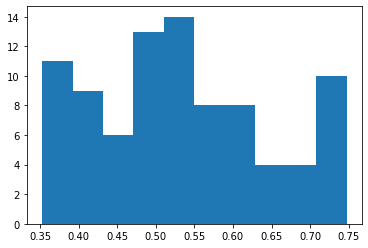

In [ ]:
all_test_preds = np.array(all_test_preds)
plt.hist(all_test_preds.mean(0))

In [ ]:
subm = pd.read_csv(root_dir+'sample_submission.csv')
subm['MGMT_value'] = all_test_preds.mean(0)
subm.to_csv("submission.csv", index=False)

In [ ]:
subm

,BraTS21ID,MGMT_value
0,1,0.567605
1,13,0.517874
2,15,0.520529
3,27,0.525541
4,37,0.624887
...,...,...
82,826,0.510444
83,829,0.537831
84,833,0.376811
85,997,0.560375
